# HCA - Hierarchical Clustering
---
  
- Agglomerative Approach to construct clusters bottom-up
- Relies entirely on a matrix of pairwise distances

## Env Preparation

In [1]:
import os
import sys
# os.chdir('/Users/pabloruizruiz/OneDrive/Courses/NLP_Stanford/Complementary_Courses/Document_Clustering')
os.chdir('/home/jovyan/work/')
print('Workdir: ', os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

Workdir:  /home/jovyan/work


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data Preparation

In [7]:
data = pd.read_csv(JP('data','bbc-text.csv'))
data['lenght'] = data.text.apply(lambda l: len(l.split(' ')))
data.head()

category                                               text  lenght
0           tech  tv future in the hands of viewers with home th...     806
1       business  worldcom boss  left books alone  former worldc...     332
2          sport  tigers wary of farrell  gamble  leicester say ...     270
3          sport  yeading face newcastle in fa cup premiership s...     390
4  entertainment  ocean s twelve raids box office ocean s twelve...     287

In [8]:
print(data.category.value_counts())
px.histogram(data, x='category',)

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [9]:
px.histogram(data, x='lenght',)
# data['lenght'].hist(bins=200)

In [10]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm') # Powerfull model with everytihing included

def spacy_cleaning(
    document,
    tags_to_keep=['JJ', 'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    entities_to_remove=['ORG,NORP,GPE,PERSON']):

    def pass_test(w, tags=tags_to_keep):
        if w.ent_type_ == 0:
                return w.tag_ in tags and not w.is_punct and not w.is_stop and w.ent_ not in entities_to_remove
        return w.tag_ in tags and not w.is_punct and not w.is_stop 

    words = [ word for word in document if pass_test(word)]
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in words ]
    return ' '.join(tokens)

In [11]:
#### Test on a sample of the data

In [12]:
sample = data.iloc[:2,:]
sample.head()

category                                               text  lenght
0      tech  tv future in the hands of viewers with home th...     806
1  business  worldcom boss  left books alone  former worldc...     332

In [13]:
sample['processed'] = sample['text'].apply(nlp).apply(spacy_cleaning)

In [14]:
print(sample['text'][0][:1000])

tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-

In [15]:
print(sample['processed'][0][:1000])

tv future hand viewer system plasma high definition tv digital video recorder move living room way people watch tv different year time accord expert panel gather annual consumer electronic discuss new technology impact favourite pastime lead trend programme content deliver viewer home network cable satellite telecom company broadband service provider room portable device talk technology ce digital personal video recorder dvr pvr set box system allow people record store play pause forward wind tv programme want technology allow personalised tv build high definition tv set big business lack high definition programming people wind advert forget abide network channel schedule put entertainment network cable satellite company worried mean term advertising revenue brand identity viewer loyalty channel lead technology moment concern raise grow uptake service happen today month year time futurologist tell like issue lose advertising revenue pressing issue moment commercial broadcaster brand lo

In [13]:
import time
start = time.time()
data['processed'] = data['text'].apply(nlp).apply(spacy_cleaning)
finish = time.time()
print('Done! It took me ', (finish-start))
data.to_csv(JP('data','bbc-text-processed.csv'))
data.head()

Done! It took me  126.66121530532837


category                                               text  lenght  \
0           tech  tv future in the hands of viewers with home th...     806   
1       business  worldcom boss  left books alone  former worldc...     332   
2          sport  tigers wary of farrell  gamble  leicester say ...     270   
3          sport  yeading face newcastle in fa cup premiership s...     390   
4  entertainment  ocean s twelve raids box office ocean s twelve...     287   

                                           processed  
0  tv future hand viewer system plasma high defin...  
1  left book ebber accuse oversee 11bn fraud acco...  
2  wary farrell gamble rush make bid decide switc...  
3  yeade face premiership face trip leader yeade ...  
4  raid ocean crime go number office chart take w...

In [4]:
data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

category                                               text  lenght  \
0           tech  tv future in the hands of viewers with home th...     806   
1       business  worldcom boss  left books alone  former worldc...     332   
2          sport  tigers wary of farrell  gamble  leicester say ...     270   
3          sport  yeading face newcastle in fa cup premiership s...     390   
4  entertainment  ocean s twelve raids box office ocean s twelve...     287   

                                           processed  
0  tv future hand viewer system plasma high defin...  
1  left book ebber accuse oversee 11bn fraud acco...  
2  wary farrell gamble rush make bid decide switc...  
3  yeade face premiership face trip leader yeade ...  
4  raid ocean crime go number office chart take w...

In [18]:
doc_list = [d for d in data.text]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 933960. Unique words: 43772


In [19]:
doc_list = [d for d in data.processed]
print('Total documents: ', len(doc_list))
docs_toguether = ' '.join(d for d in doc_list)
all_words = docs_toguether.split(' ')
unique_words = np.unique(all_words)
print('All words: {}. Unique words: {}'.format(len(all_words), len(unique_words)))

Total documents:  2225
All words: 339642. Unique words: 15191


## TFIDF

In [5]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print('Clusters k = ', NUM_CLUSTERS)


Clusters k =  5


In [7]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))
# vectorizer

In [8]:
tfidf = vectorizer.fit_transform(data['processed'].copy())
tfidf_df = pd.DataFrame(
    tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
0 0.000   0.062   0.000 0.046  0.130    0.000     0.069 0.000 0.000    0.000   
1 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.181 0.000    0.000   
2 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.390   
3 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   
4 0.000   0.164   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   

   ...   try  turn   use  want   way  week   win  work  world  year  
0  ... 0.000 0.000 0.000 0.343 0.100 0.000 0.000 0.049  0.000 0.065  
1  ... 0.325 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000 0.000  
2  ... 0.000 0.000 0.195 0.000 0.164 0.166 0.000 0.000  0.000 0.000  
3  ... 0.000 0.000 0.000 0.000 0.000 0.000 0.109 0.000  0.000 0.000  
4  ... 0.157 0.000 0.000 0.000 0.000 0.133 0.123 0.000  0.000 0.000  

[5 rows x 168 columns]

**There are 168 unique grams in 2225 documents with the given constraints**

## Moving to a Catalog Format

In [9]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [10]:
catalog = Catalog()
catalog.documents = documents

In [11]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
tfidf.representation.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
0 0.000   0.062   0.000 0.046  0.130    0.000     0.069 0.000 0.000    0.000   
1 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.181 0.000    0.000   
2 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.390   
3 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   
4 0.000   0.164   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   

   ...   try  turn   use  want   way  week   win  work  world  year  
0  ... 0.000 0.000 0.000 0.343 0.100 0.000 0.000 0.049  0.000 0.065  
1  ... 0.325 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000 0.000  
2  ... 0.000 0.000 0.195 0.000 0.164 0.166 0.000 0.000  0.000 0.000  
3  ... 0.000 0.000 0.000 0.000 0.000 0.000 0.109 0.000  0.000 0.000  
4  ... 0.157 0.000 0.000 0.000 0.000 0.133 0.123 0.000  0.000 0.000  

[5 rows x 168 columns]

**We actually have already a vocab in our Model instance**

In [12]:
[ (k,v) for i,(k,v) in enumerate(tfidf.token2id.items()) if i<5 ]

[('future', 49), ('hand', 61), ('system', 148), ('high', 65), ('way', 162)]

## Clustering

In [13]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scripts.algorithms.clustering import (
    hca_document_clustering, plot_dendogram_from_linkage_matrix)

In [14]:
METHOD = 'ward'
DISTANCE = 'cosine'
NUM_CLUSTERS = 5

In [15]:
def retrieve_doc_idx_by_level(cluster_idx, idx):
    ''' Return the indexes of the documents that match the cluster id '''
    doc_ids = np.array(list(range(len(cluster_idx))))
    mask = cluster_idx==idx
    return [c for c,i in zip(doc_ids,mask) if i]

In [115]:
def retrieve_hca_info(Z, criterion='maxclust', min_clusters=2, max_clusters=None):
    ''' Retrive the documents that belong to each cluster 
    for every merge done during the HCA process ''' 
    if not max_clusters: max_clusters = len(Z)//2+1
    cluster_dict = defaultdict(lambda: defaultdict(list))
    for level in range(max_clusters, min_clusters-1, -1):
        cluster_idx = fcluster(Z, level, criterion=criterion)
        for c in range(1,1+level):
            cluster_dict[level][c] = retrieve_doc_idx_by_level(cluster_idx,c)
    return cluster_dict

In [113]:
Z = hca_document_clustering(
    tfidf, method=METHOD, distance_metric=DISTANCE)
print(Z.shape)
Z

[INFO]: Computing Distance Matrix using cosine distance
[INFO]: Performing Hierarchical Clustering using ward linkage
(2224, 4)


array([[6.350e+02, 1.936e+03, 0.000e+00, 2.000e+00],
       [7.930e+02, 1.880e+03, 0.000e+00, 2.000e+00],
       [9.020e+02, 1.732e+03, 0.000e+00, 2.000e+00],
       ...,
       [4.424e+03, 4.445e+03, 7.346e+00, 1.612e+03],
       [4.438e+03, 4.440e+03, 8.732e+00, 6.130e+02],
       [4.446e+03, 4.447e+03, 9.607e+00, 2.225e+03]])

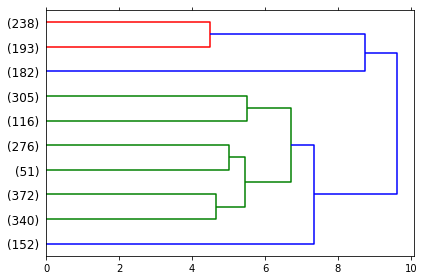

In [114]:
plot_dendogram_from_linkage_matrix(
    Z, truncate_mode='lastp', p=10, 
    show_leaf_counts=True, leaf_rotation=0.)

In [110]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 8
CRITERION = 'maxclust'
cluster_dict = retrieve_hca_info(Z, CRITERION, MIN_CLUSTERS, MAX_CLUSTERS)
# cluster_dict[5]

In [117]:
# words_dict
# pd.DataFrame(cluster_dict)

### Aggregate Clusters and Calculate Centroid / Medoids


In [106]:
def calc_centroid(arr):
    return arr.mean(axis=0)

def calc_medoid(arr):
    return arr[np.argmin(squareform(pdist(arr)).sum(axis=0))]

def calc_euclidean_medoid(arr):
    return np.median(arr, axis=0)

In [107]:
medoids_ = defaultdict(np.array)
centroids_ = defaultdict(np.array)
for c,idx in cluster_dict[NUM_CLUSTERS].items():
    cluster_docs = tfidf.representation.loc[idx].values
    medoids_[c] = calc_medoid(np.array(cluster_docs))
    centroids_[c] = calc_centroid(np.array(cluster_docs))

## Words per Cluster

In [108]:
centroids = pd.DataFrame(centroids_).T
centroids.columns=tfidf_df.columns
# centroids.index = ['C{}'.format(i) for i in range(NUM_CLUSTERS)]
centroids.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
1 0.015   0.012   0.011 0.041  0.023    0.000     0.018 0.044 0.010    0.044   
2 0.020   0.023   0.026 0.035  0.028    0.012     0.020 0.024 0.024    0.024   
3 0.007   0.024   0.016 0.031  0.010    0.070     0.016 0.008 0.030    0.016   
4 0.007   0.020   0.014 0.025  0.004    0.001     0.017 0.010 0.020    0.008   
5 0.013   0.005   0.015 0.039  0.012    0.001     0.010 0.009 0.012    0.028   

   ...   try  turn   use  want   way  week   win  work  world  year  
1  ... 0.027 0.013 0.017 0.045 0.034 0.034 0.043 0.034  0.015 0.041  
2  ... 0.023 0.019 0.042 0.041 0.035 0.033 0.032 0.049  0.036 0.077  
3  ... 0.016 0.015 0.015 0.019 0.015 0.030 0.008 0.020  0.027 0.095  
4  ... 0.008 0.018 0.010 0.016 0.012 0.037 0.102 0.037  0.026 0.077  
5  ... 0.049 0.020 0.014 0.039 0.032 0.039 0.166 0.028  0.060 0.066  

[5 rows x 168 columns]

In [109]:
medoids = pd.DataFrame(medoids_).T
medoids.columns=tfidf_df.columns
# medoids.index = ['M{}'.format(i) for i in range(NUM_CLUSTERS)]
medoids.head()

able  accord  action   add  allow  analyst  announce   ask  base  believe  \
1 0.000   0.000   0.000 0.000  0.000    0.000     0.169 0.000 0.000    0.000   
2 0.000   0.000   0.041 0.028  0.079    0.000     0.000 0.000 0.075    0.110   
3 0.000   0.000   0.000 0.000  0.000    0.077     0.156 0.000 0.070    0.000   
4 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.000   
5 0.000   0.000   0.000 0.000  0.000    0.000     0.000 0.000 0.000    0.029   

   ...   try  turn   use  want   way  week   win  work  world  year  
1  ... 0.000 0.000 0.000 0.120 0.000 0.125 0.116 0.060  0.000 0.000  
2  ... 0.091 0.060 0.091 0.075 0.061 0.016 0.086 0.000  0.046 0.108  
3  ... 0.068 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000 0.219  
4  ... 0.065 0.000 0.000 0.000 0.055 0.000 0.257 0.000  0.000 0.106  
5  ... 0.235 0.032 0.000 0.000 0.000 0.000 0.393 0.000  0.049 0.047  

[5 rows x 168 columns]

In [127]:
def best_words(cluster_tfidf):
    best_words = defaultdict(float)
    for c in range(1, NUM_CLUSTERS+1):
        best_words[c] = cluster_tfidf.loc[c].\
            sort_values(ascending=False).index.to_list()
    return best_words

best_words_medoids = best_words(medoids)
best_words_centroids = best_words(centroids)


In [128]:
for c,idx in cluster_dict[NUM_CLUSTERS].items():
    print('Cluster {} Nº Documents: {}\n  Centroid Words: {}\n  Medoid Words: {}'.format(
        c, tfidf.representation.loc[idx].shape[0], 
        best_words_centroids[c][:5], best_words_medoids[c][:5]))


Cluster 1 Nº Documents: 152
  Centroid Words: ['election', 'party', 'leader', 'government', 'people']
  Medoid Words: ['election', 'party', 'leader', 'member', 'announce']
Cluster 2 Nº Documents: 1039
  Centroid Words: ['people', 'year', 'new', 'government', 'music']
  Medoid Words: ['government', 'people', 'right', 'british', 'new']
Cluster 3 Nº Documents: 421
  Centroid Words: ['firm', 'sale', 'company', 'share', 'market']
  Medoid Words: ['company', 'share', 'sale', 'plan', 'fall']
Cluster 4 Nº Documents: 182
  Centroid Words: ['film', 'star', 'win', 'include', 'director']
  Medoid Words: ['film', 'win', 'star', 'life', 'british']
Cluster 5 Nº Documents: 431
  Centroid Words: ['game', 'win', 'play', 'player', 'match']
  Medoid Words: ['game', 'win', 'team', 'try', 'leave']


## Retrieve keywords by level in 1 function

In [131]:
print(cluster_dict.keys())
print(cluster_dict[3].keys())

dict_keys([8, 7, 6, 5, 4, 3, 2])
dict_keys([1, 2, 3])


In [138]:
def words_for_cluster(cluster_dict):
    ''' Retrieve the list of words that characterizes each cluster 
    for each cluster'''
    words_dict = defaultdict(lambda: defaultdict(list))
    for level_id, cluster in cluster_dict.items():
        for cluster_id, doc_indexes in cluster.items():
            cluster_docs = tfidf.representation.loc[doc_indexes].values
            cluster_centroid = calc_centroid(cluster_docs)
            words_dict[level_id][cluster_id] = best_words(cluster_centroid)
    return words_dict

In [139]:
words_for_cluster(cluster_dict)

defaultdict(<function __main__.words_for_cluster.<locals>.<lambda>()>,
            {8: defaultdict(list,
                         {1: array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.169, 0.   , 0.   ,
                                 0.   , 0.   , 0.   , 0.   , 0.084, 0.   , 0.   , 0.   , 0.   ,
                                 0.   , 0.074, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
                                 0.   , 0.07 , 0.   , 0.   , 0.067, 0.   , 0.   , 0.   , 0.   ,
                                 0.607, 0.   , 0.   , 0.073, 0.   , 0.   , 0.   , 0.   , 0.   ,
                                 0.   , 0.068, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.056,
                                 0.   , 0.067, 0.084, 0.149, 0.   , 0.   , 0.   , 0.   , 0.   ,
                                 0.   , 0.   , 0.   , 0.   , 0.072, 0.   , 0.074, 0.   , 0.   ,
                                 0.   , 0.   , 0.   , 0.   , 0.066, 0.085, 0.069, 0.254, 0.08 ,
                            

**RECALL REAL DISTRIBUTION OF CATEGORIES**


In [28]:
print(data.category.value_counts())


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


#### Filter best N words of each cluster in common

In [29]:
def best_words(N, BEST_WORDS_PER_CLUSTER):
    global NUM_CLUSTERS
    words = set()
    for i in range(1,NUM_CLUSTERS+1):
        for word in BEST_WORDS_PER_CLUSTER[i][:N]:
            words.add(word)
    return list(words)

N = 50
words = best_words(N, best_words_centroids)
print('{} unique words after grouping the {} most important words of the {} clusters'.format(
    len(words), N, NUM_CLUSTERS))
print('{} words are shared'.format(N*NUM_CLUSTERS - len(words)))
print('Some common words {}'.format(words[:6]))


140 unique words after grouping the 50 most important words of the 5 clusters
110 words are shared
Some common words ['day', 'star', 'service', 'game', 'home', 'use']


## Visualization 

#### Helper Functions for Plotting

In [30]:
def define_subplots(n_cols,n_plots,figsize=None):
    '''Return the axes given a total 
    of plots and desired number of columns'''
    j = 1 if n_plots%n_cols != 0 else 0
    n_rows = (n_plots // n_cols) + j 
    print(n_rows,n_cols)
    if not figsize: 
        figsize=(n_cols*5,n_rows*5)
    
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols, sharex=False, sharey=False,
        figsize=figsize)
    return fig,axs # .reshape(n_plots,-1)

In [31]:
def plot_scores_by_methods(
    scores:list, max_words:int=5, 
    n_cols=3, figsize=(15,10)):
    ''' Create a subplot for each of the methods passed '''
    _, axs = define_subplots(n_cols,len(scores),figsize)
    print(axs.shape)
    
    for c, (method, values) in enumerate(scores.items()):
        words = scores_by_method[method].word[:max_words]
        scores_by_method[method]\
            .loc[:,['word',method]][:max_words].set_index('word')\
            .plot.bar(
                rot =45, width=0.8, title=method.upper(), legend=False,
                ax=axs[c // n_cols, c % n_cols])
        # axs[c // n_cols, c % n_cols].axis()
    plt.tight_layout()
    plt.show()
    return

### Data to desired format

In [32]:
centroid_scores = centroids.copy()
centroid_scores.index = ['k{}'.format(i) for i in range(NUM_CLUSTERS)]
centroid_scores = centroid_scores.T
centroid_scores = centroid_scores.rename_axis('word').reset_index()


In [33]:
medoid_scores = medoids.copy()
medoid_scores.index = ['k{}'.format(i) for i in range(NUM_CLUSTERS)]
medoid_scores = medoid_scores.T
medoid_scores = medoid_scores.rename_axis('word').reset_index()
medoid_scores.head(3)

word    k0    k1    k2    k3    k4
0    able 0.000 0.000 0.000 0.000 0.000
1  accord 0.000 0.000 0.000 0.000 0.000
2  action 0.000 0.041 0.000 0.000 0.000

In [34]:
centroid_scores_flat = pd.melt(
    centroids.rename_axis('cluster').reset_index(), 
       id_vars=['cluster'], var_name='word', value_name='score')

medoid_scores_flat = pd.melt(
    medoids.rename_axis('cluster').reset_index(), 
       id_vars=['cluster'], var_name='word', value_name='score')
medoid_scores_flat.head(3)


cluster  word  score
0        1  able  0.000
1        2  able  0.000
2        3  able  0.000

---

---

# Plotting the WordClouds


In [35]:
%matplotlib inline

In [36]:
from wordcloud import WordCloud
def cluster_to_wordcloud(
    df, max_words=200, use_mask=False, bgcolor='black'):
    ''' Convert 1 cluster into a WordCloud given:
        - The TFIDF for the cluster
        - The Score Method that give imporance to the word '''
    # Create the wordcloud attending to the inverse of idf
    wordcloud = WordCloud(
        max_words=max_words, 
        mask=mask_ if use_mask else None,
        background_color=bgcolor).generate_from_frequencies(
            frequencies=dict(zip(df.word, df.score)))
    return wordcloud

In [37]:
def plot_centroids_as_wordclouds(
    word_scores,
    NUM_CLUSTERS = None,
    max_words_per_cloud=100, 
    use_mask=False, n_cols=2, figsize=(15,15)):

    if not NUM_CLUSTERS:
        NUM_CLUSTERS = word_scores.cluster.nunique()

    n_plots = NUM_CLUSTERS
    _, axs = define_subplots(n_cols,n_plots, figsize)
    
    for c in range(NUM_CLUSTERS):
        wordcloud = cluster_to_wordcloud(
            df=word_scores[word_scores.cluster == c+1],
            max_words=max_words_per_cloud,
            use_mask=use_mask)
        
        # Plot the resulting wordcloud
        axs[c // n_cols, c % n_cols].imshow(wordcloud)
        axs[c // n_cols, c % n_cols].axis('off')
    plt.tight_layout()
    plt.show()
    return

### Centroid

3 2


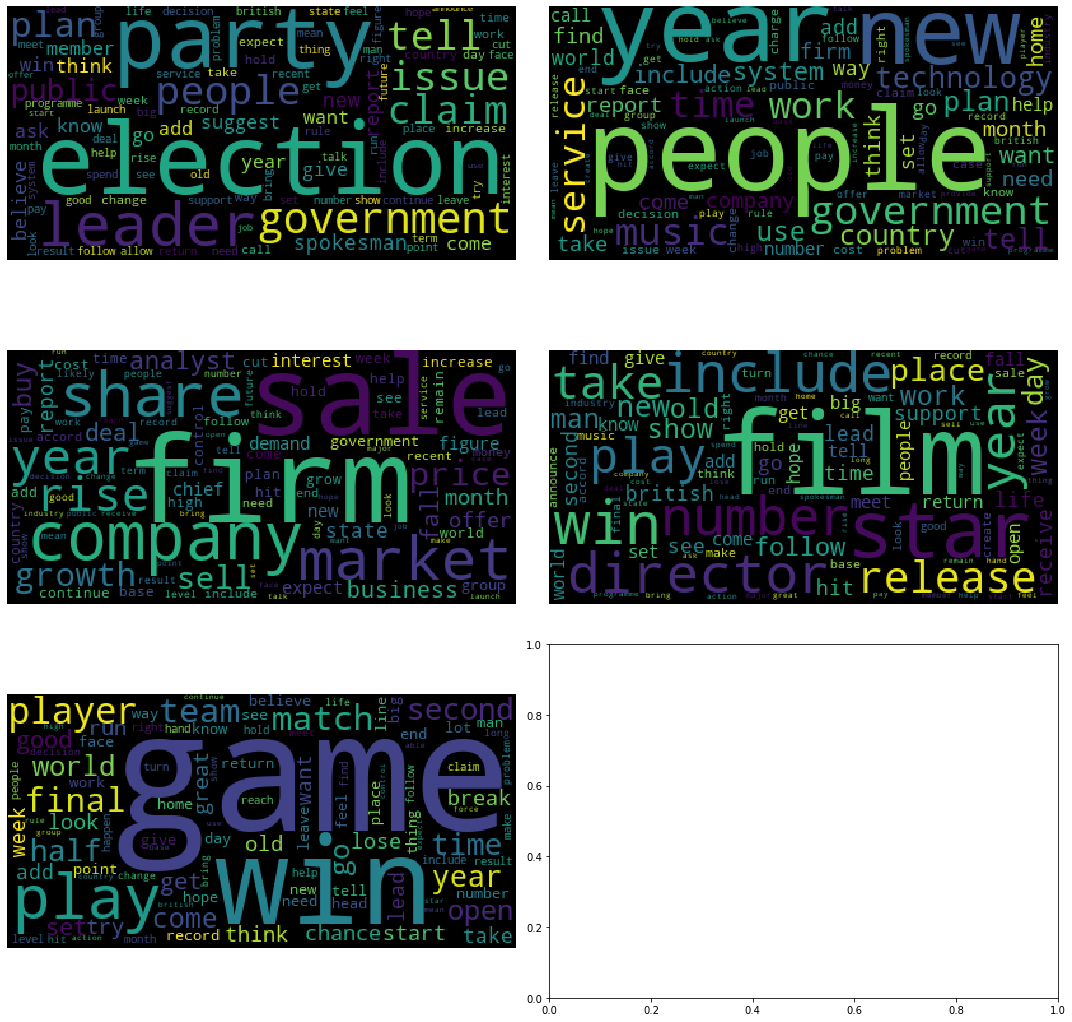

In [38]:
plot_centroids_as_wordclouds(centroid_scores_flat,n_cols=2)

### Medoid

3 2


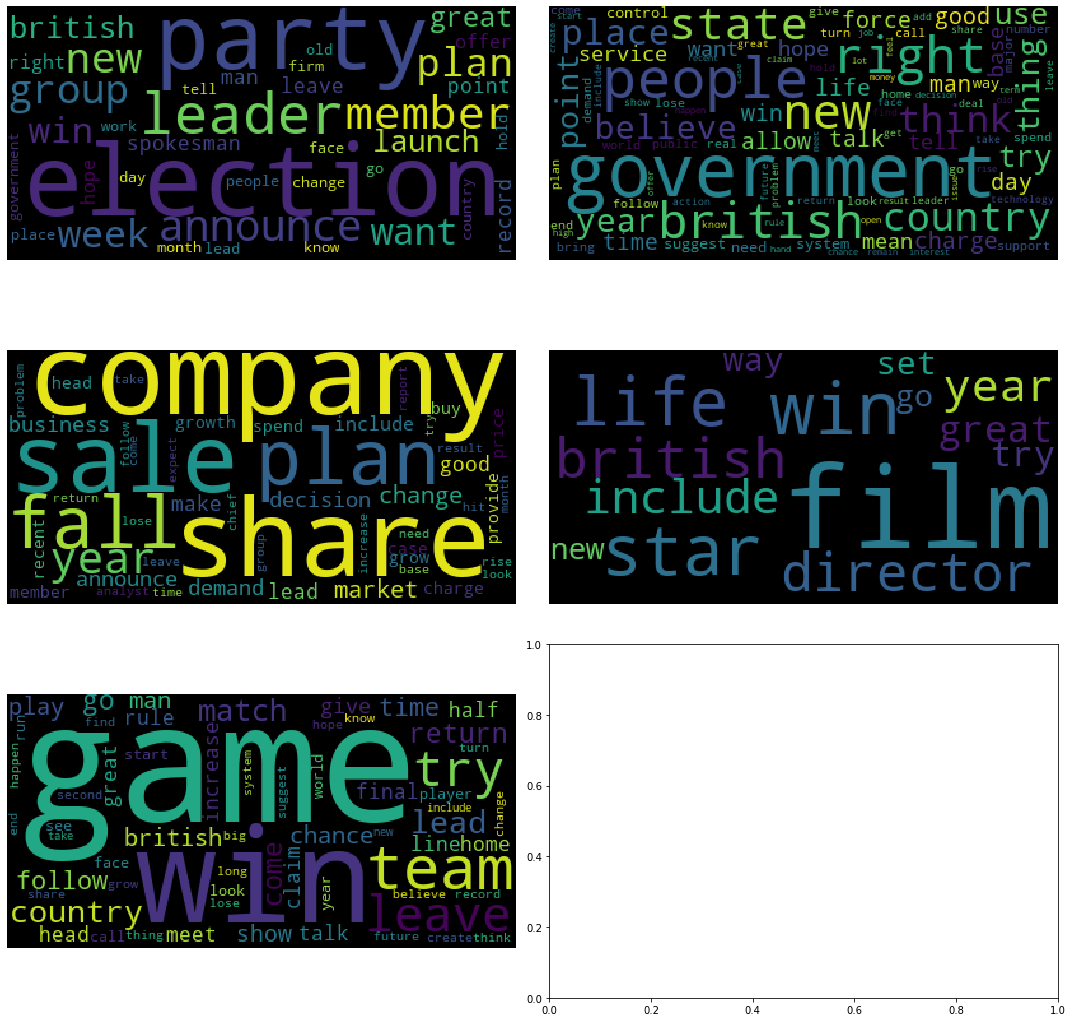

In [39]:
plot_centroids_as_wordclouds(medoid_scores_flat,n_cols=2)

# Validation

**According to importants words of cluster lets assigned a classification:**

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [80]:
for c,idx in cluster_dict[NUM_CLUSTERS].items():
    print('Cluster {} Nº Documents: {}\n  Centroid Words: {}\n  Medoid Words: {}'.format(
        c, tfidf.representation.loc[idx].shape[0], 
        best_words_centroids[c][:5], best_words_medoids[c][:5]))

Cluster 1 Nº Documents: 152
  Centroid Words: ['election', 'party', 'leader', 'government', 'people']
  Medoid Words: ['election', 'party', 'leader', 'member', 'announce']
Cluster 2 Nº Documents: 1039
  Centroid Words: ['people', 'year', 'new', 'government', 'music']
  Medoid Words: ['government', 'people', 'right', 'british', 'new']
Cluster 3 Nº Documents: 421
  Centroid Words: ['firm', 'sale', 'company', 'share', 'market']
  Medoid Words: ['company', 'share', 'sale', 'plan', 'fall']
Cluster 4 Nº Documents: 182
  Centroid Words: ['film', 'star', 'win', 'include', 'director']
  Medoid Words: ['film', 'win', 'star', 'life', 'british']
Cluster 5 Nº Documents: 431
  Centroid Words: ['game', 'win', 'play', 'player', 'match']
  Medoid Words: ['game', 'win', 'team', 'try', 'leave']


TypeError: 'float' object is not subscriptable

In [81]:
# cluster_preds = ['sport', 'entertainment', 'business', 'tech', 'politics']  
cluster_preds = ['politics', 'tech', 'business', 'entertainment', 'sports']  
d = dict(zip(range(NUM_CLUSTERS), cluster_preds))
d

{0: 'politics', 1: 'tech', 2: 'business', 3: 'entertainment', 4: 'sports'}

# Data Preparation for level 5

In [82]:
print('Total docs: ', sum([len(cluster_dict[5][i]) for i in cluster_dict[5]]))
labels = [None] * sum([len(cluster_dict[5][i]) for i in cluster_dict[5]])
for i in range(1,NUM_CLUSTERS+1):
    for j in cluster_dict[5][i]:
        labels[j] = i-1
    
labels[:10]

Total docs:  2225


[1, 1, 1, 1, 3, 0, 0, 4, 1, 3]

In [83]:
data['predict'] = [d[i] for i in labels]

In [84]:
print(data.category.value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [85]:
print(data.predict.value_counts())

tech             1039
sports            431
business          421
entertainment     182
politics          152
Name: predict, dtype: int64


In [86]:
cm = confusion_matrix(
    y_true=data.category, 
    y_pred = data.predict, 
    labels=cluster_preds)

pd.DataFrame(cm, columns=cluster_preds, index=cluster_preds)

politics  tech  business  entertainment  sports
politics            145   257        11              0       4
tech                  1   294        50              2      54
business              3   176       326              0       5
entertainment         1   162        22            179      22
sports                0     0         0              0       0

## What is this shit?

# TreeMap

In [99]:
import plotly.graph_objects as go

In [102]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/sales_success.csv')
print(df.head())

   Unnamed: 0 region   county salesperson  calls  sales
0           0  North   Dallam          JE     35     23
1           1  North   Dallam          ZQ     49     13
2           2  North   Dallam          IJ     20      6
3           3  North  Hartley          WE     39     37
4           4  North  Hartley          PL     42     37


In [103]:
levels = ['salesperson', 'county', 'region'] # levels used for the hierarchical chart
color_columns = ['sales', 'calls']
value_column = 'calls'

In [104]:
def build_hierarchical_dataframe(df, levels, value_column, color_columns=None):
    """
    Build a hierarchy of levels for Sunburst or Treemap charts.

    Levels are given starting from the bottom to the top of the hierarchy, 
    ie the last level corresponds to the root.
    """
    df_all_trees = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
        dfg = df.groupby(levels[i:]).sum(numerical_only=True)
        dfg = dfg.reset_index()
        df_tree['id'] = dfg[level].copy()
        if i < len(levels) - 1:
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'total'
        df_tree['value'] = dfg[value_column]
        df_tree['color'] = dfg[color_columns[0]] / dfg[color_columns[1]]
        df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
    total = pd.Series(dict(id='total', parent='', 
                              value=df[value_column].sum(),
                              color=df[color_columns[0]].sum() / df[color_columns[1]].sum()))
    df_all_trees = df_all_trees.append(total, ignore_index=True)
    return df_all_trees


df_all_trees = build_hierarchical_dataframe(df, levels, value_column, color_columns)
df_all_trees

id    parent value  color
0      AX   Houston    42  0.214
1      BI   Hartley    24  0.333
2      BS  Brewster    33  0.424
3      DQ  Presidio    40  0.375
4      DS     Duval    42  0.214
..    ...       ...   ...    ...
68   East     total   407  0.393
69  North     total   631  0.605
70  South     total   381  0.507
71   West     total   321  0.589
72  total            1740  0.531

[73 rows x 4 columns]

In [101]:
go.Treemap(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total')

NameError: name 'df_all_trees' is not defined